# Homework 2 Part 2 - Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Problem 1 (15 points)

**In this data you will working with the [Wine Dataset](https://archive.ics.uci.edu/ml/datasets/wine):**

In [2]:
from sklearn.datasets import load_wine
wine = load_wine(return_X_y=False)
# print(wine.DESCR)

**Let's load this data into a ```pandas``` dataframe:**

In [3]:
import pandas as pd

df = pd.DataFrame(np.hstack((wine.target[:,np.newaxis],wine.data)), columns=['Class']+wine.feature_names)
df

,Class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,0.0,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,0.0,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,0.0,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,0.0,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,2.0,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,2.0,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,2.0,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,2.0,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


## Problem Set

**Answer the following questions:**

1. **Implement k-Means for the 13 wine features. Use the silhouette index and rand index to determine which value of $k$ best works for this data. Justify your answer.**

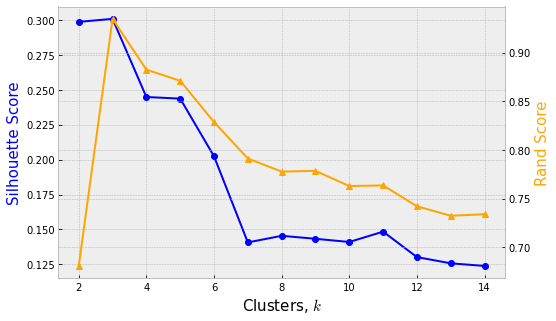

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

## Loading data and Standardization
X = df[df.columns[1:]].to_numpy() # Training Data
scaler = MinMaxScaler() # Scaling data using standardization
X_scaled = scaler.fit_transform(X)

## Routine to determine which k value works best for each criteria
ss = [] # silhouette score
rs = [] # rand score
for k in range(2,15):
    labels = KMeans(k,random_state=1).fit_predict(X_scaled) # Training K-Means
    ss+=[silhouette_score(X_scaled, labels)] #appending silhouette score for clustering results
    rs+=[rand_score(wine.target, labels)] #appending rand score for clustering results

## Plotting results
fig,ax=plt.subplots(figsize=(8,5))
ax.plot(range(2,15), ss,'-ob', label='Silhouette Score')
ax.set_xlabel('Clusters, $k$',size=15); ax.set_ylabel('Silhouette Score',c='b',size=15)
ax2=ax.twinx(); ax2.plot(range(2,15), rs, '-^',color='orange', label='Rand Score')
ax2.set_ylabel('Rand Score',c='orange',size=15);

As seen from the plot above, the best value of $k$ according to the Silhouette index is $k=3$. (Different partitions of the data or different random seeds may change the results.)

Since we know the number of classes in the training data (3 different types of wine) and their correspondent labels, it is not surprising that the best value for $k$ is for $k=3$. However, the rand score is not 1 for $k=3$, indicating that K-Means with Euclidean distance has difficulty in grouping some samples.

2. **For the *optimal* value of $k$ found in the previous question, predict the clustering labels. Compute the silhouette index and the rand index for the predicted labels.**

In [5]:
# Training the final clustering algorithms (with the nest returned k value)

labels = KMeans(3).fit_predict(X_scaled)

In [6]:
# Computing the rand score

print('Silhouette Score: ', silhouette_score(X_scaled, labels)) 

print('Rand Score: ', rand_score(wine.target, labels)) 

Silhouette Score:  0.3013463273503232
Rand Score:  0.941471465752555


Moreover, from the silhouette score, we can see that the formed clusters are do not satisfy at least one of the silhouette score conditions for compactness and separability.

---

# Problem 2 (15 points)

**The starter code below is an incomplete implementation of the EM algorithm to optimize a Gaussian Mixture Model data likelihood.**

**In this problem, you will complete the provided code by filling in the empty slots (do not use any library or online implementations).**

In [9]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def EM_GaussianMixture(X, NumComponents, MaximumNumberOfIterations=100, DiffThresh=1e-4, display=False):
    '''This function implements the EM algorithm for a Gaussian Mixture Model
    
    Input:
    X - n-d array of size N-by-D (feature matrix).
    NumComponents - integer (>0). Number of Gaussian components.
    MaximumNumberOfIterations - integer (>0). Maximum number of EM steps or iterations.
    DiffThresh - float (>=0). Convergence criteria measuring difference between consecutive point estimators.
    
    Output:
    Means - n-d array of size (NumComponents)x(D). Estimated Gaussian means.
    Sigs - n-d array of size (D)x(D)x(NumComponents). Estimated covariance matrices.
    Ps - n-d array of size (NumComponents)x1. Estimated probability contribution for each mixture (pis).
    pZ_X - n-darray of size (N)x(NumComponents). Estimated membership probabilities for each data point in each component, P(zi|xi).'''
    
    # Size of the input data: N number of points, D features
    N, D = X.shape

    # Initialize Parameters of each Component K
    Means = np.zeros((NumComponents,D))
    Sigs = np.zeros(((D, D, NumComponents)))
    Ps = np.zeros(NumComponents)
    for i in range(NumComponents):
        rVal = np.random.uniform(0,1)
        Means[i,:] = X[max(1,round(N*rVal)),:]
        Sigs[:,:,i] = 1*np.eye(D)
        Ps[i] = 1/NumComponents

    # E-Step Solve for p(z | x, Theta(t)) = Cik
    pZ_X = np.zeros((N,NumComponents))
    for k in range(NumComponents):
        # Assign each point to a (multivariate) Gaussian component with probability pi(k)
        pZ_X[:,k] = multivariate_normal.pdf(X, Means[k,:], Sigs[:,:,k])*Ps[k]
    pZ_X = (pZ_X.T/np.sum(pZ_X,axis=1)).T 

    Diff = np.inf
    NumberIterations = 1
    while Diff > DiffThresh and NumberIterations < MaximumNumberOfIterations:
        ## M-step: Update Means, Sigs, Ps
        MeansOld = Means.copy()
        SigsOld = Sigs.copy()
        PsOld = Ps.copy()
        for k in range(NumComponents):
            ## Complete M-step: Update parameters
            #Means
            Means[k,:] = X.T@pZ_X[:,k]/sum(pZ_X[:,k])

            #Sigs
            xDiff = X-MeansOld[k,:]            
            J = np.zeros((D,D))
            for i in range(N):
                J = J + pZ_X[i,k]*np.outer(xDiff[i,:], xDiff[i,:])
            Sigs[:,:,k] = J / sum(pZ_X[:,k])

            #Ps
            Ps[k] = sum(pZ_X[:,k]) / N

        ## E-step: Solve for p(z | x, Theta(t))
        # Complete E-step
        for k in range(NumComponents):
            # Assign each point to a Gaussian component with probability pi(k)
            pZ_X[:,k] = multivariate_normal.pdf(X, Means[k,:], Sigs[:,:,k])*Ps[k]
        pZ_X = (pZ_X.T/np.sum(pZ_X,axis=1)).T

        Diff = sum(sum(abs(MeansOld - Means))) + sum(sum(sum(abs(SigsOld - Sigs)))) + sum(abs(PsOld - Ps))
        if display:
            print('t = ',NumberIterations,': \t', Diff)
        NumberIterations = NumberIterations + 1
    return Means, Sigs, Ps, pZ_X

---

# Problem 3 (15 points)

**Using your code in problem 3, determine the mixture proportion, mean and (diagonal) covariance associated with each of the mixture component in the data contained in mixture.txt.**

**In your solution include:**

* **a plot where each data point is color-coded by their weight responsabilities (you have been provided with the plotting script).**

* **a plot where each data point is color-coded by their cluster membership.**

**Answer the following questions:**

1. **How many mixture components are found in the data?**

2. **How did you determine this?**

3. **What did you estimate for the mixture components, means and covariances associated with each mixture component?**

t =  1 : 	 9.32199943535931
t =  2 : 	 2.684977746311598
t =  3 : 	 1.9828678781730447
t =  4 : 	 1.248761067590171
t =  5 : 	 1.0055815243421826
t =  6 : 	 0.8251464329678457
t =  7 : 	 0.7075023428975102
t =  8 : 	 0.6107944022200347
t =  9 : 	 0.5369686345093088
t =  10 : 	 0.46590791642342744
t =  11 : 	 0.39509294646062826
t =  12 : 	 0.33203244704343765
t =  13 : 	 0.24371506085762898
t =  14 : 	 0.17901716672387383
t =  15 : 	 0.15284030985307462
t =  16 : 	 0.1507533548240408
t =  17 : 	 0.1581560137267634
t =  18 : 	 0.16485068588359333
t =  19 : 	 0.16513834000327784
t =  20 : 	 0.15903165878384198
t =  21 : 	 0.15331747019993108
t =  22 : 	 0.14693681890512544
t =  23 : 	 0.14177530565116336
t =  24 : 	 0.1395375182166487
t =  25 : 	 0.1369342679541699
t =  26 : 	 0.13132397180388888
t =  27 : 	 0.12219044318384947
t =  28 : 	 0.10984857952665308
t =  29 : 	 0.09603485366263557
EM Algorithm. # Components: 5
---------------------
Component 1
Estimated Means
[2.47390855 2.4478

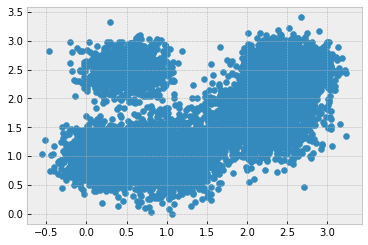

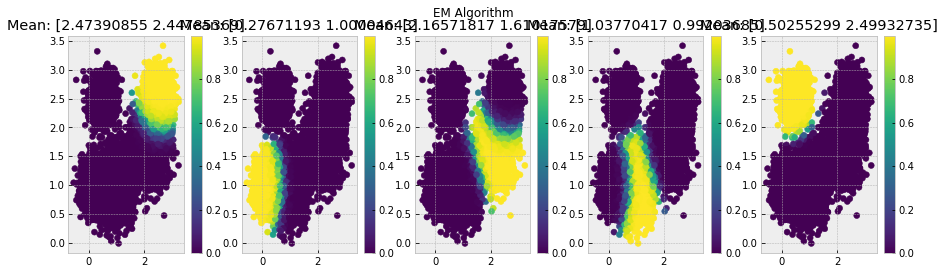

In [22]:
import warnings
warnings.filterwarnings("ignore")

## Load Data
X = np.loadtxt('mixture.txt')
plt.scatter(X[:,0],X[:,1]);

## Set number of components
NumComponents = 5
EM_Means, EM_Sigs, EM_Ps, pZ_X = EM_GaussianMixture(X, NumComponents,50,0.1, True)

print('EM Algorithm. # Components: ' + str(NumComponents))
print('---------------------')
for i in range(NumComponents):
    print('Component '+str(i+1))
    print('Estimated Means')
    print(EM_Means[i,:])
    print('Estimated Covariances')
    print(EM_Sigs[:,:,i])
    print('Estimated Weights')
    print(EM_Ps[i])
    print('---------------------')
    
fig = plt.figure(figsize=(15, 4))
plt.suptitle('EM Algorithm')
for i in range(NumComponents):
    ax = fig.add_subplot(1,NumComponents,i+1)
    p1 = ax.scatter(X[:,0], X[:,1], c=pZ_X[:,i]) 
    ax.set_title('Mean: '+ str(EM_Means[i,:]))
    fig.colorbar(p1, ax=ax);

* The plot where each data point is color-coded by their cluster membership can be found below:

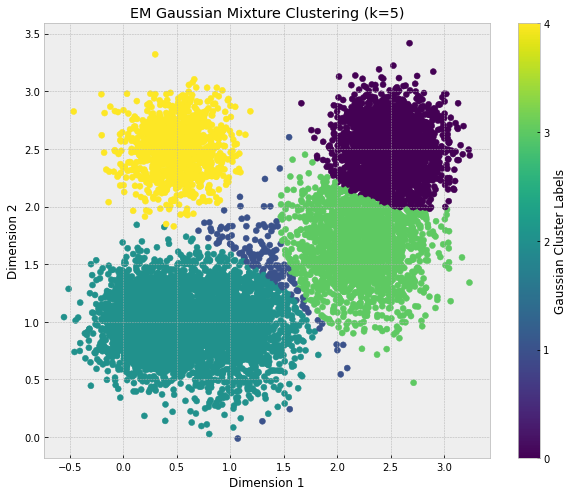

In [18]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], c = np.argmax(pZ_X,axis=1))
plt.title('EM Gaussian Mixture Clustering (k=' + str(NumComponents) + ')')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(ticks=range(NumComponents), label='Gaussian Cluster Labels');

## Method 1 - Qualitative Approach

After running the algorithm for the same value $k=5$, the algorithm converges to the same solution. This consistency brings confidence on the value selected for $k$.

When we introduce clustering, we will discuss metrics that will allow to choose the value $k$ with quantitative measurements.

## Method 2 - Quantitative Approach

Now that we have introduced cluster validity metrics, we can use them to better make selections on the optimal value for $k$,

The silhouette index, allows us to compute an internal cluster validity score for each clustering result. We select the value $k$ that maximizes this score.

k that maximizes the Silhouette Index is  4


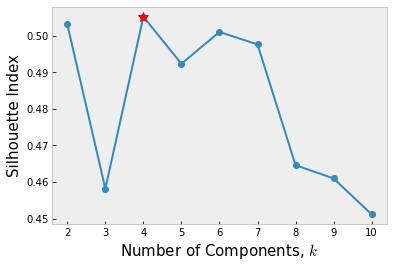

In [19]:
# from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

kvalues=range(2,11)
s=[]
for k in kvalues:
    _, _, _, pZ_X = EM_GaussianMixture(X, NumComponents,50,0.1, False)
    labels = np.argmax(pZ_X, axis=1)
#     GMM = GaussianMixture(n_components=k, random_state=0).fit(X)
#     labels = GMM.predict(X)
    s+= [silhouette_score(X, labels)]
    
koptimal = kvalues[np.argmax(s)]
print('k that maximizes the Silhouette Index is ', koptimal)
plt.plot(kvalues,s,'-o'); plt.grid()
plt.plot(koptimal,s[np.argmax(s)],'*r',ms=10)
plt.xlabel('Number of Components, $k$',size=15)
plt.ylabel('Silhouette Index',size=15);

Note that for each $k$ value, the clutering algorithm starts with a random initialization for the cluster centroids. As we know, the initialization will lead to a different solution. For this reason, you may obtain a different plot if you run this notebook multiple times.

In order to mitigate the effects of the initialization, let's recreate this exercise using the ```scikit-learn``` function which has the option to initial the centroids with those found from k-means. In addition, let's also fix the random seed:

k that maximizes the Silhouette Index is  3


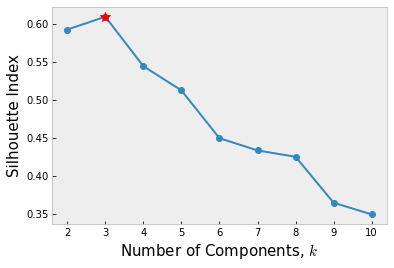

In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

kvalues=range(2,11)
s=[]
for k in kvalues:
    GMM = GaussianMixture(n_components=k, random_state=0,init_params='kmeans').fit(X)
    labels = GMM.predict(X)
    s+= [silhouette_score(X, labels)]
    
koptimal = kvalues[np.argmax(s)]
print('k that maximizes the Silhouette Index is ', koptimal)
plt.plot(kvalues,s,'-o'); plt.grid()
plt.plot(koptimal,s[np.argmax(s)],'*r',ms=10)
plt.xlabel('Number of Components, $k$',size=15)
plt.ylabel('Silhouette Index',size=15);

Using this approach, we see that $k=3$ maximizes the silhouette index score.

For this selected value $k=3$, we can find the estimated parameters as follows:

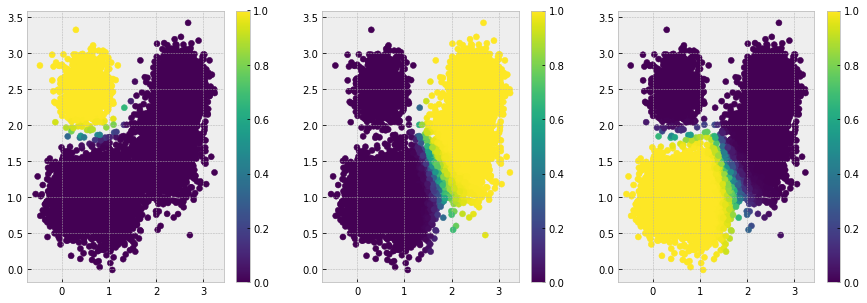

EM Algorithm. # Components: 3
---------------------
Component 1
Estimated Means
[0.50469595 2.4985903 ]
Estimated Covariances
[[ 0.06086558 -0.00024366]
 [-0.00024366  0.05047589]]
Estimated Weights
0.10719981617842472
---------------------
Component 2
Estimated Means
[2.37489299 2.14997304]
Estimated Covariances
[[0.09053272 0.05425221]
 [0.05425221 0.23126198]]
Estimated Weights
0.45092829581250987
---------------------
Component 3
Estimated Means
[0.59007226 1.00383413]
Estimated Covariances
[[0.2163851  0.00349624]
 [0.00349624 0.07303962]]
Estimated Weights
0.4418718880090625
---------------------


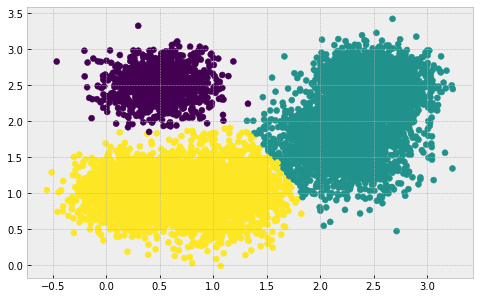

In [21]:
GMM = GaussianMixture(n_components=koptimal, random_state=0).fit(X)
labels = GMM.predict(X)
probs = GMM.predict_proba(X)
Sigmas = GMM.covariances_
Means = GMM.means_
Pis = GMM.weights_

fig=plt.figure(figsize=(15,5))
for i in range(koptimal):
    ax = fig.add_subplot(1,koptimal,i+1)
    p1 = ax.scatter(X[:,0], X[:,1], c=probs[:,i])
    fig.colorbar(p1, ax=ax);
plt.show()
    
plt.figure(figsize=(8,5))
plt.scatter(X[:,0], X[:,1], c=labels);

print('EM Algorithm. # Components: ' + str(koptimal))
print('---------------------')
for i in range(koptimal):
    print('Component '+str(i+1))
    print('Estimated Means')
    print(Means[i,:])
    print('Estimated Covariances')
    print(Sigmas[i,:,:])
    print('Estimated Weights')
    print(Pis[i])
    print('---------------------')

___